In [165]:
import pandas as pd
import numpy as np

In [166]:
df = pd.read_csv('bank/bank-full.csv', delimiter=';')

In [167]:
df_selected_columns = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

In [168]:
# TARGET ENCODING
df_selected_columns.loc[:, 'y'] = df_selected_columns['y'].replace({'yes': 1, 'no': 0})

C:\Users\ctw02071\AppData\Local\Temp\ipykernel_38316\3993669423.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_selected_columns.loc[:, 'y'] = df_selected_columns['y'].replace({'yes': 1, 'no': 0})


In [207]:
# SPLIT THE DATA
from sklearn.model_selection import train_test_split

df_fulltrain, df_test = train_test_split(df_selected_columns, test_size=0.2)
len(df_fulltrain), len(df_test)

(36168, 9043)

In [202]:
df_fulltrain.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

In [170]:
df_train, df_val = train_test_split(df_fulltrain, test_size=0.25)
len(df_train), len(df_val)

(27126, 9042)

In [171]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values.astype(int)
y_val = df_val.y.values.astype(int)
y_test = df_test.y.values.astype(int)

del df_train['y']
del df_val['y']
del df_test['y']

# Question 1: ROC AUC feature importance

In [172]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [173]:
from sklearn.metrics import roc_auc_score

auc_scores = {}

for feature in numerical_columns:
    preds = df_train[feature].values
    
    auc = roc_auc_score(y_train, preds)
    
    if auc < 0.5:
        preds = -preds
        auc = roc_auc_score(y_train, preds)
    
    auc_scores[feature] = auc

for feature, auc in auc_scores.items():
    print(f"{feature}: AUC = {auc:.2f}")

age: AUC = 0.50
balance: AUC = 0.59
day: AUC = 0.53
duration: AUC = 0.81
campaign: AUC = 0.57
pdays: AUC = 0.59
previous: AUC = 0.60


# Question 2: Training the model

In [174]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model= LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [175]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)  

y_pred = model.predict_proba(X_val)[:, 1] 

auc_val = roc_auc_score(y_val, y_pred)

print(f"AUC on validation set: {auc_val:.2f}")

AUC on validation set: 0.91


# Question 3: Precision and Recall

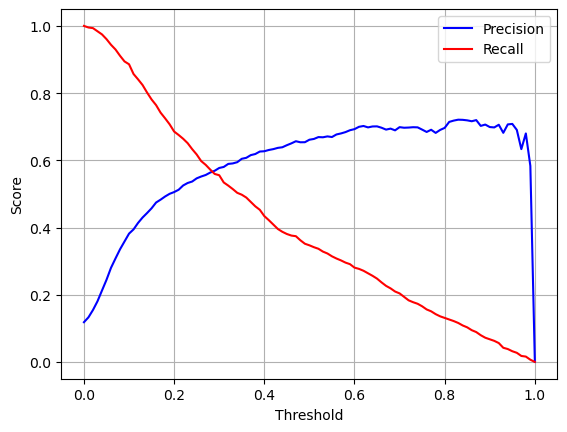

In [184]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label="Precision", color='blue')
plt.plot(thresholds, recalls, label="Recall", color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [185]:

diffs = np.abs(np.array(precisions) - np.array(recalls))
intersection_threshold = thresholds[np.argmin(diffs)]

threshold_range = (thresholds >= 0.2) & (thresholds <= 0.4)

diffs_limited = diffs[threshold_range]
thresholds_limited = thresholds[threshold_range]

intersection_threshold = thresholds_limited[np.argmin(diffs_limited)]
print(f"Refined intersection threshold: {intersection_threshold}")



Refined intersection threshold: 0.28


# Question 4: F1 score

In [189]:
f1_scores = []

for precision, recall in zip(precisions, recalls):
    if precision + recall == 0: 
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    f1_scores.append(f1)

max_f1_threshold = thresholds[np.argmax(f1_scores)]

print(max_f1_threshold)

0.22


# Question 5: 5-Fold CV

In [190]:
from sklearn.model_selection import KFold

In [216]:
df_selected_columns['y'] = df_selected_columns['y'].astype(int)
df_fulltrain, df_test = train_test_split(df_selected_columns, test_size=0.2)

df_fulltrain = df_fulltrain.reset_index(drop=True)  # Ensure indices are clean
y_fulltrain = df_fulltrain['y'].values

df_fulltrain = df_fulltrain.drop(columns=['y'])

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kf.split(df_fulltrain):

    df_train = df_fulltrain.iloc[train_idx]
    df_val = df_fulltrain.iloc[val_idx]
    
    y_train = y_fulltrain[train_idx]
    y_val = y_fulltrain[val_idx]
    

    train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

mean_auc = np.mean(auc_scores)
auc_std = np.std(auc_scores)

# Print the results
print(f"AUC scores for each fold: {auc_scores}")
print(f"Mean AUC across all folds: {mean_auc:.3f}")
print(f"STD AUC across all folds: {auc_std:.3f}")


C:\Users\ctw02071\AppData\Local\Temp\ipykernel_38316\4139785716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_columns['y'] = df_selected_columns['y'].astype(int)


AUC scores for each fold: [0.9026098029056997, 0.9150127601291023, 0.8960425798604158, 0.9044712375904143, 0.9038354883418434]
Mean AUC across all folds: 0.904
STD AUC across all folds: 0.006


# Question 6: Hyperparameter Tuning

In [222]:
C_values = [0.000001, 0.001, 1]

best_c = None
best_mean_auc = 0
best_auc_scores = []

for C_value in C_values:
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        auc_scores = []
        
        for train_idx, val_idx in kf.split(df_fulltrain):
            df_train = df_fulltrain.iloc[train_idx]
            df_val = df_fulltrain.iloc[val_idx]
            y_train = y_fulltrain[train_idx]
            y_val = y_fulltrain[val_idx]

            train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
            X_train = dv.fit_transform(train_dict)

            model = LogisticRegression(solver='liblinear', C=C_value, max_iter=1000)
            model.fit(X_train, y_train)

            val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
            X_val = dv.transform(val_dict)

            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            auc_scores.append(round(auc, 3))

        mean_auc = np.mean(auc_scores)
        auc_std = np.std(auc_scores)
        
        print(f"c value: {C_value}, mean: {mean_auc:.3f}, std: {auc_std:.3f}")
        
        if mean_auc > best_mean_auc:
            best_mean_auc = mean_auc
            best_c = C_value
            best_auc_scores = auc_scores

print("Best values")
print( best_c, best_mean_auc, best_auc_scores)

c value: 1e-06, mean: 0.696, std: 0.005
c value: 0.001, mean: 0.861, std: 0.009
c value: 1, mean: 0.904, std: 0.006
Best values
1 0.9044000000000001 [0.903, 0.915, 0.896, 0.904, 0.904]
